In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
path = Path('../data/facebook')
list(path.iterdir())

[PosixPath('../data/facebook/test_y.csv'),
 PosixPath('../data/facebook/train_woheader_sample.csv'),
 PosixPath('../data/facebook/._test_y.csv'),
 PosixPath('../data/facebook/after_eda'),
 PosixPath('../data/facebook/train.csv'),
 PosixPath('../data/facebook/fea_sample'),
 PosixPath('../data/facebook/._fea_sample'),
 PosixPath('../data/facebook/._train_y.csv'),
 PosixPath('../data/facebook/._after_eda'),
 PosixPath('../data/facebook/._train.csv'),
 PosixPath('../data/facebook/train_y.csv')]

In [4]:
df_final_train = read_hdf(path/'fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf(path/'fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefrential_attachment_followees', 'prefrential_attachment_followers',
       'svd_dot_u', 'svd_dot_v'],
      dtype='objec

In [6]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [7]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)


Estimators =  10 Train Score 0.9225558958492301 test Score 0.9110900073863037
Estimators =  50 Train Score 0.92039816519487 test Score 0.9102916203693998
Estimators =  100 Train Score 0.920653149861143 test Score 0.9156853706575033
Estimators =  250 Train Score 0.9205579138872044 test Score 0.9130718266905037
Estimators =  450 Train Score 0.9211882927441365 test Score 0.9139803046881576


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

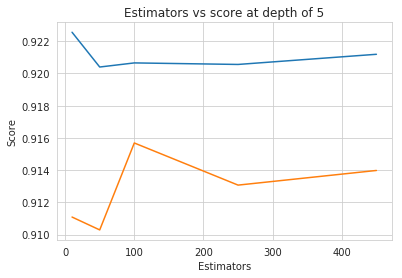

In [8]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Estimators = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
    

Depth =  3 Train Score 0.9105984882904464 test Score 0.8898420908765954
Depth =  9 Train Score 0.958159166445772 test Score 0.9237350641687564
Depth =  11 Train Score 0.9613585519625789 test Score 0.924957326196447
Depth =  15 Train Score 0.9631405697565735 test Score 0.9255442456428737
Depth =  20 Train Score 0.9637659095061203 test Score 0.9264575878762367
Depth =  35 Train Score 0.9638603153971913 test Score 0.9264142201255212
Depth =  50 Train Score 0.9638603153971913 test Score 0.9264142201255212
Depth =  70 Train Score 0.9638603153971913 test Score 0.9264142201255212
Depth =  130 Train Score 0.9638603153971913 test Score 0.9264142201255212


Text(0.5, 1.0, 'Depth vs score at depth of 5 at estimators = 115')

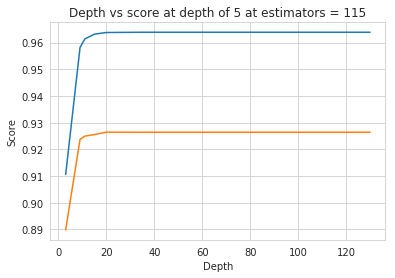

In [9]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=i, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Depth = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
    

In [10]:
params_dict = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)


rf_random = RandomizedSearchCV(clf, param_distributions=params_dict,
                               n_iter=5,cv=10,scoring='f1',random_state=25,
                               return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96216193 0.96179416 0.9605583  0.96171077 0.96319681]
mean train scores [0.96298262 0.96273906 0.9611566  0.96242675 0.96404858]


In [11]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [12]:
clf = rf_random.best_estimator_

In [13]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [14]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9650954018441313
Test f1 score 0.9270881597236847


In [15]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    P = C / C.sum(axis=0)
    R = C.T / C.sum(axis=1).T
    
    sns.set_style(None)
    plt.figure(figsize=(15,5))
    labels = [0,1]
    cmap = sns.light_palette('blue')
    plt.subplot(1, 3, 1)
    annot_kws = {"ha": 'center',"va": 'center'}
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws=annot_kws)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


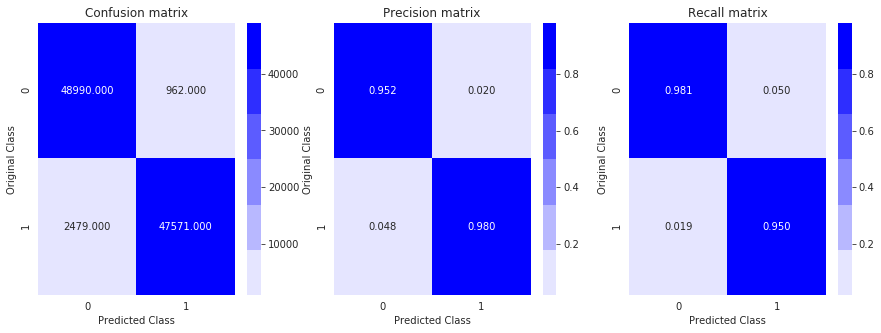

Test confusion_matrix


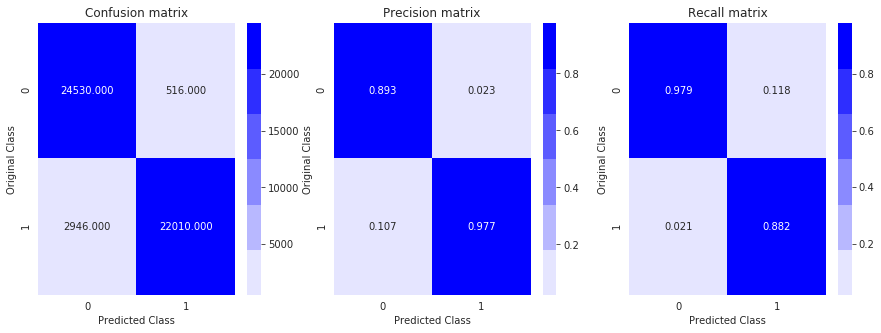

In [16]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

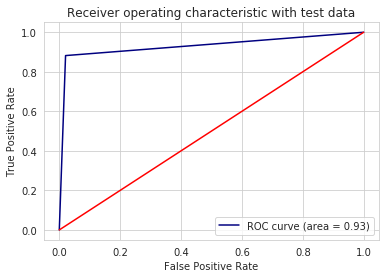

In [17]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()


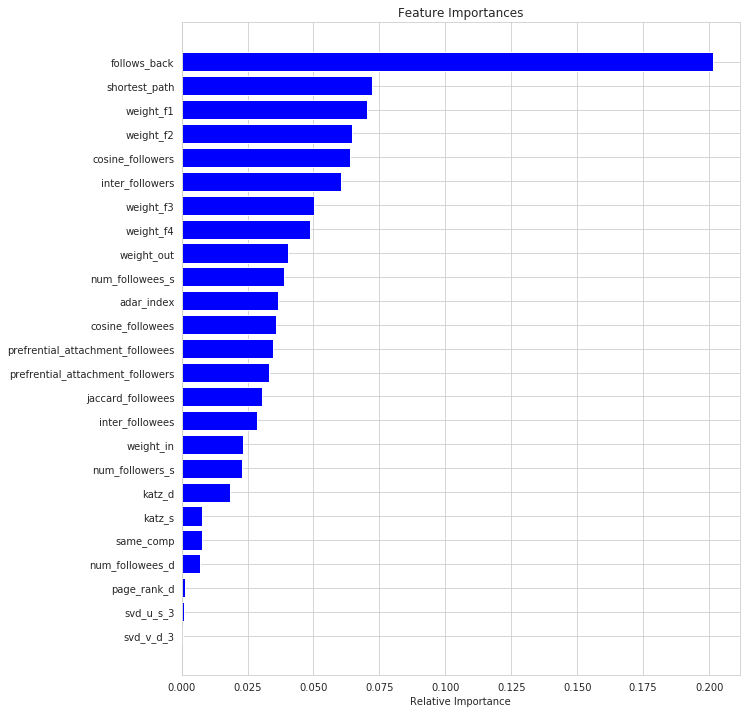

In [18]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


## Using XGBoost Model

In [19]:
import xgboost as xgb

In [20]:
clf = xgb.XGBClassifier(random_state=25, n_jobs=-1)
clf.fit(df_final_train, y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train, y_train_pred))
print('Test f1 score',f1_score(y_test, y_test_pred))

Train f1 score 0.9734189003158149
Test f1 score 0.9231718211596546


Estimators =  10 Train Score 0.9435473879826554 test Score 0.9250930814699511
Estimators =  50 Train Score 0.9721782539875806 test Score 0.9318719378273357
Estimators =  100 Train Score 0.9765140399696434 test Score 0.9308351857732614
Estimators =  250 Train Score 0.9858967910672971 test Score 0.9207984270815524
Estimators =  450 Train Score 0.9940302095436515 test Score 0.9045191243789729


Text(0.5, 1.0, 'Estimators vs score')

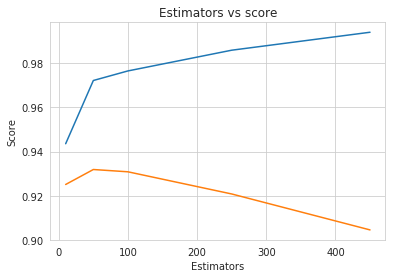

In [22]:
### Hyper-param search for estimators
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Estimators = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')
    

Depth =  3 Train Score 0.9262623677925622 test Score 0.9250861755197294
Depth =  9 Train Score 0.9432941249367468 test Score 0.9249510824970018
Depth =  11 Train Score 0.9442198030067392 test Score 0.926487353798083
Depth =  15 Train Score 0.9519904392977828 test Score 0.9273660421990834
Depth =  20 Train Score 0.9592112537625163 test Score 0.9278093507700759
Depth =  35 Train Score 0.9669144528393859 test Score 0.9290186571097291
Depth =  50 Train Score 0.9721782539875806 test Score 0.9318719378273357
Depth =  70 Train Score 0.9740859069932553 test Score 0.9327549724925942
Depth =  100 Train Score 0.9765140399696434 test Score 0.9308351857732614


Text(0.5, 1.0, 'Depth vs score')

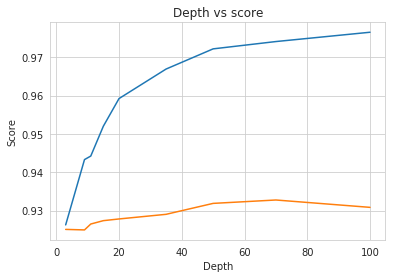

In [24]:
### Hyper-param search for depth

depths = [3, 9, 11, 15, 20, 35, 50, 70, 100]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Depth = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(depths, train_scores, label='Train Score')
plt.plot(depths, test_scores, label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score')

In [42]:
params_dict = {
    "n_estimators":sp_randint(100, 200),
    "max_depth": sp_randint(20, 50),
    'min_child_weight': sp_randint(1, 10),
    "learning_rate": [0.5, 0.3, 0.1, 0.01, 0.03, 0.05]
}

clf = xgb.XGBClassifier(random_state=25)


rf_random = RandomizedSearchCV(clf, param_distributions=params_dict,
                               n_iter=5, cv=5, scoring='f1', random_state=25,
                               return_train_score=True, n_jobs=-1)

rf_random.fit(df_final_train, y_train)
print('mean test scores', rf_random.cv_results_['mean_test_score'])
print('mean train scores', rf_random.cv_results_['mean_train_score'])

mean test scores [0.97747517 0.97732447 0.9783159  0.98155999 0.97404809]
mean train scores [0.99295057 0.99100558 0.99822871 0.99999501 0.98742919]


In [43]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.3,
       max_delta_step=0, max_depth=27, min_child_weight=4, missing=None,
       n_estimators=188, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=25, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [44]:
clf = rf_random.best_estimator_

In [45]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [46]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999900100898093
Test f1 score 0.9259707449631659


Train confusion_matrix


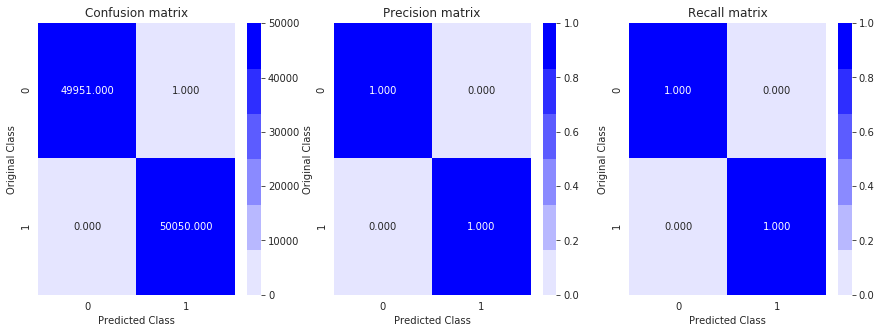

Test confusion_matrix


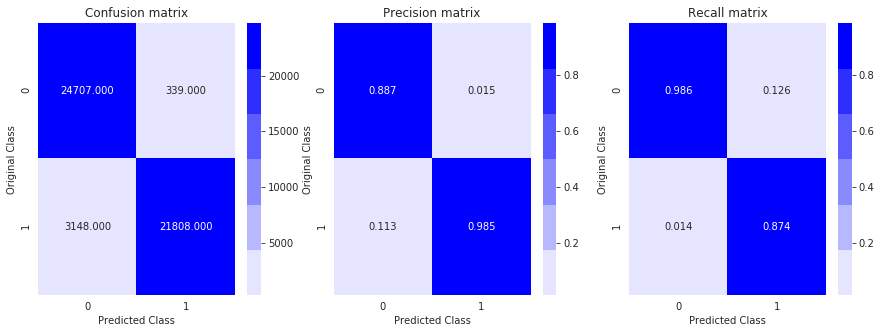

In [47]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

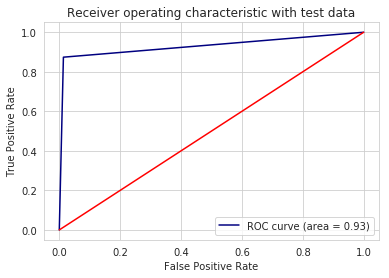

In [48]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

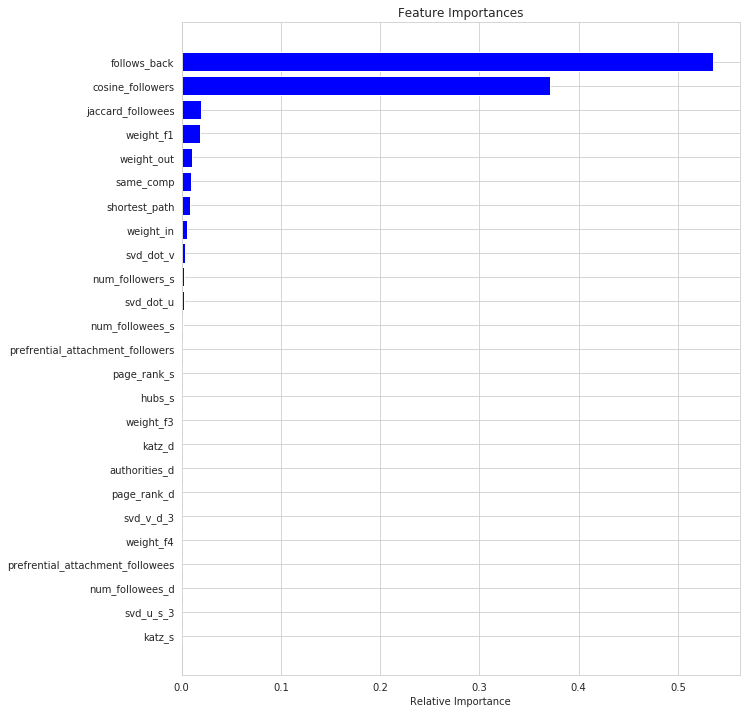

In [49]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()